# Result Evaluation & Merge

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
import merge
import load

## Team performance on test data

### Test data
To be able to compare team performances we agreed on a common test set. We generated it by splitting the original training data into 70% training and 30% test rows. Together with the actual submission, each team handed in their prediction for test set. This chapter evaluates these predictions.

### Mean accuracy

In [2]:
mean_accuracies = merge.mean_accuracies()

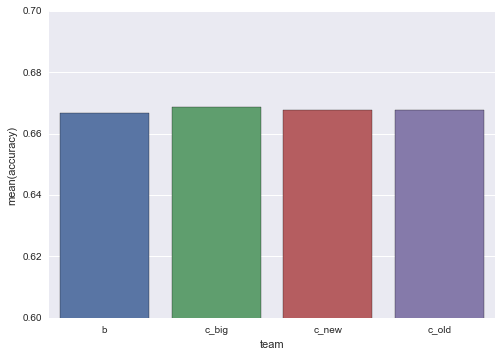

In [96]:
mean_accuracies_df = pd.DataFrame(mean_accuracies, columns=['accuracy'])
mean_accuracies_df.index.name = 'team'
mean_accuracies_df = mean_accuracies_df.reset_index()
ax = sns.barplot(x=mean_accuracies_df['team'], y=mean_accuracies_df['accuracy'])
lim = ax.set_ylim([0.6, 0.7])

All teams showed similar accuracies around **67%** on the test set.

### Split performance
All teams realisied that their classifiers performance depends highly on the amount of historical knowledge, e.g., the number of products returned by a customer. This realisation led us to divide classification into *splits* of known and unknown values. The figure below shows the size of each split and the accuracy of each team.

In [148]:
splits = merge.evaluate_split_performance()

### Split sizes

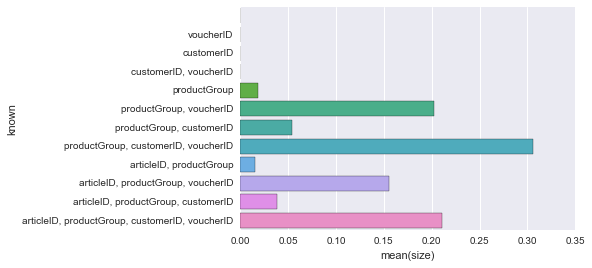

In [151]:
ax = sns.barplot(x='size', y=splits.index, data=splits)

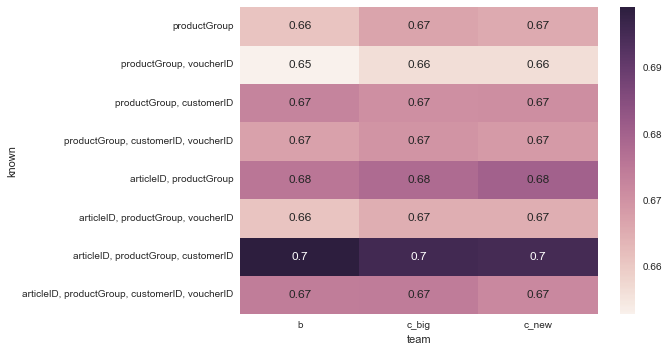

In [99]:
teams = load.team_names()
split_accuracies = splits.ix[4:,['b', 'c_big', 'c_new']]
split_accuracies.columns.name = 'team'
min_acc = split_accuracies.min().min()
max_acc = split_accuracies.max().max()
ax = sns.heatmap(split_accuracies, vmin=min_acc, vmax=max_acc, annot=True)

### Split sizes

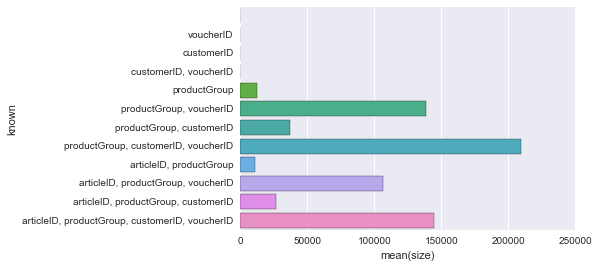

In [137]:
ax = sns.barplot(x='size', y=splits.index, data=splits)

The known splits *nothing known*, *only voucherID*, *only customerID* and *customerID and voucherID* do appear in the target data, but not this test set. They are removed from this figre. 

Again, the submissions show similar performance.

### Prediction differences
The predictions differ and the question is to what extent. The figure below shows the percentage of rows that have different classifications.

In [66]:
differences = merge.distinct_predictions()

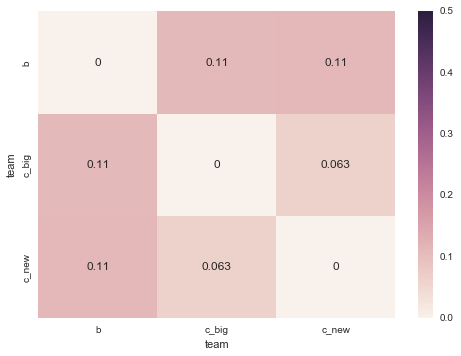

In [98]:
ax = sns.heatmap(differences.ix[:3, :3], vmin=0, vmax=0.5, annot=True)

The classifications provided by team C are similiar to each other. *c_big* was generated using a greater sampling of the training data, than *c_new*. This lead to a 6% difference and classification.

The classifications between team C and B differ in 11% of the rows.

### Prediction differences by split
The differences can be explored in greater detail by looking at the splits. The figure below shows the differnces.

In [138]:
split_differences = merge.distinct_split_predictions()

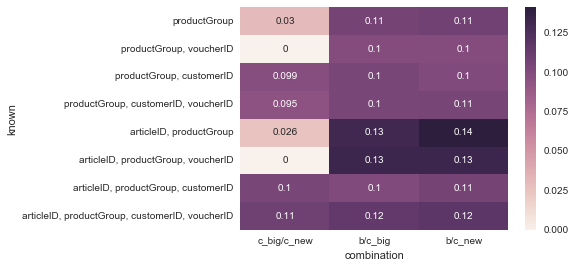

In [143]:
ax = sns.heatmap(split_differences.ix[4:, ['c_big/c_new', 'b/c_big', 'b/c_new']], annot=True)

Alas, the disagreements are not in few splits but evenly distributed.

## Team performance on target data

### Prediction differences

In [101]:
result_differences = merge.distinct_predictions(test=False)

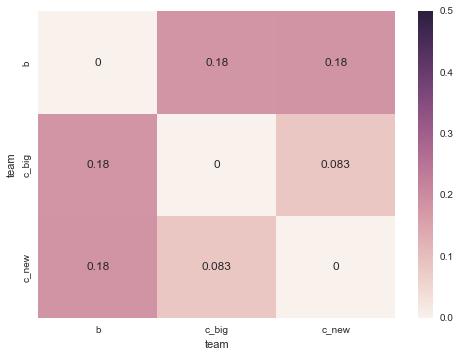

In [102]:
ax = sns.heatmap(result_differences.ix[:3, :3], vmin=0, vmax=0.5, annot=True)

### Split sizes in target data

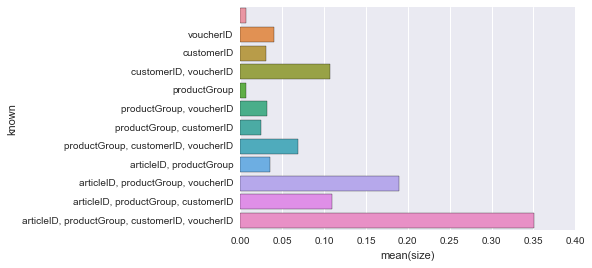

In [146]:
original_split_sizes = merge.original_split_sizes()
ax = sns.barplot(x='size', y=splits.index, data=original_split_sizes)

### Prediction differences by split

In [114]:
result_split_differences = merge.distinct_split_predictions(test=False)

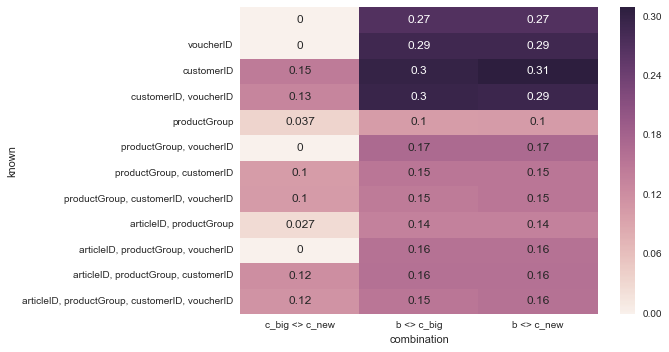

In [115]:
ax = sns.heatmap(result_split_differences.ix[:, ['c_big <> c_new', 'b <> c_big', 'b <> c_new']], annot=True)

## Merge data

In [118]:
merged = merge.merge()
merged

team                                           b                 c_big  \
result                                confidence prediction confidence   
orderID  articleID colorCode sizeCode                                    
a1744178 i1002632  3097      I          0.701320          0   0.500000   
         i1003278  1097      40         0.723813          0   0.570000   
         i1003279  1114      40         0.714540          0   0.500000   
                   1116      40         0.714540          0   0.620000   
                   1117      40         0.714540          0   0.600000   
a1744179 i1001147  1001      42         0.267293          1   0.595477   
         i1001151  3082      42         0.336710          1   0.628530   
         i1001160  1108      42         0.307641          1   0.580849   
         i1001461  2493      42         0.315724          1   0.559468   
         i1001480  1001      42         0.319979          1   0.523900   
         i1003229  2112      42         0.286497          0   0.516347   
a1744180 i1000477  1001      38         0.801953          1   0.740000   
                             40         0.801953          1   0.790000   
                   1092      38         0.801953          1   0.780000   
                             40         0.801953          1   0.820000   
                   1093      38         0.801953          1   0.780000   
                             40         0.801953          1   0.810000   
         i1002579  1101      A          0.695478          1   0.750000   
         i1002580  1093      I          0.700323          1   0.720000   
                   1117      I          0.700323          1   0.720000   
         i1003237  1092      40         0.742278          1   0.800000   
                   1093      40         0.742278          1   0.810000   
                   1096      40         0.742278          1   0.810000   
         i1003244  1001      38         0.808203          1   0.690000   
                             40         0.808203          1   0.710000   
                   1111      38         0.808203          1   0.710000   
                             40         0.808203          1   0.790000   
a1744181 i1003656  7178      29         0.332231          1   0.590000   
a1744182 i1001153  1096      40         0.634327          1   0.670000   
         i1001155  1112      42         0.641684          1   0.650000   
...                                          ...        ...        ...   
a1855487 i1002643  1108      I          0.552732          1   0.500000   
         i1003944  1082      34         0.697340          1   0.710000   
a1855488 i1003695  7219      31         0.511464          1   0.528049   
         i1004377  10224     30         0.502594          1   0.634781   
a1855489 i1001138  1096      36         0.693367          0        NaN   
         i1002506  1012      38         0.637402          0        NaN   
a1855490 i1003941  1082      44         0.842730          0   0.790000   
a1855491 i1003274  3097      40         0.617999          1   0.560000   
         i1004339  30342     40         0.502594          1   0.510000   
a1855492 i1004338  20197     40         0.612314          0   0.805836   
a1855493 i1001163  1111      38         0.631509          0   0.650000   
a1855494 i1001155  1001      38         0.258953          0   0.650561   
         i1004137  10109     38         0.502594          1   0.664597   
a1855495 i1003660  7211      30         0.652364          1   0.610000   
         i1003956  1113      40         0.642034          1   0.680000   
a1855496 i1004181  10114     40         0.683944          1   0.540000   
         i1004213  10001     40         0.683944          1   0.540000   
         i1004332  10001     40         0.683944          1   0.580000   
         i1004341  10108     40         0.683944          1   0.580000   
         i1004549  20109     A          0.683944          1   0.540000   
a185

# Ensemble predictions

## Approach 1: Weighted Majority Vote

We use the following formula for the final $prediction_i$, with $i$ being the row index. In it, each $prediction_{c,i}$ of classifier $c$ is weighted.

$$
row_i = 
\dfrac
    {\sum_{c \in C} 
        prediction_{c,i} 
        \cdot weight_{c,i}} 
    {\sum_{c \in C} weight_{c,i}}
$$

The $weight_{c,i}$ takes into account the condfidence of $c$ in row $i$, the mean confidence of $c$ over all rows, the overall accuracy of $c$ and the mean accuracy of all classifiers.

$$
weight_{c,i} = \dfrac{confidence_{c,i}}{confidence_{c,\varnothing}} \cdot \bigg(\dfrac{accuracy_c}{accuracy_\varnothing}\bigg)^2
$$

The confidences returned by the classifiers are, as such, not comparable to each other. They differ in meaning and in range. To counteract and to avoid favoring classifiers that are generally -maybe mistakenly- confident, we take the confidence compared to the classifier's mean confidence.

The accuracy, we believe, is the best predictor of a classifier's performance in the target set. We take this information from a test set that each group used to evaluate their classifier. The test set is a 70/30 split of the training data. We compare the accuracy to the mean accuracy of all classifiers. As the difference tends to be big in information, but small in extent, the ratio is squared.

In [ ]:
merge.majority_vote(merge.merge(team_results), accuracies)